# 40 - Flat NER - Qualitative analysis 

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(os.environ["CUDA_VISIBLE_DEVICES"])

2


In [5]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset"
else:
  BASE = Path(os.path.dirname(os.path.realpath("__file__"))).resolve() # If not on GColab, BASE will be the directory of this notebook
  DATASETS = Path('/work/stual/dataset_ICDAR').resolve() #Your data 
  OUT_BASE = Path('/work/stual/res_ICDAR/method_0').resolve()

print(sys.path)
print(BASE)
print(DATASETS)
print(OUT_BASE)

['/lrde/home2/stual/stage_DAS/m0_flat_ner', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages']
/lrde/home2/stual/stage_DAS/m0_flat_ner
/work/stual/dataset_ICDAR
/work/stual/res_ICDAR/method_0


## Models list

Choose a fine-tuned model to perform qualitative analysis. You can choose between the models you fine-tuned and store locally or load models from the HuggingFace.

In [6]:
import glob

def show_models_from_several_sources(Source,OUT_BASE):
    models = []
    if Source == 'Local':
        models_list = sorted(glob.glob(f"{OUT_BASE}/tmp/*/checkpoint*"))
        for m in models_list:
            l = m.split('/')
            l = '/'.join(l[-3:])
            models.append(l)
    elif Source == 'Online':
        models = ['nlpso/m0_flat_ner_ref_camembert_ner',
                 'nlpso/m0_flat_ner_ref_ptrn_camembert_ner',
                 'nlpso/m0_flat_ner_ocr_camembert_ner',
                 'nlpso/m0_flat_ner_ocr_ptrn_camembert_ner']
    return models

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
        
localisation = widgets.Dropdown(
    options=['Local', 'Online'],
    value='Local',
    description='Model localisation:',
)
localisation

Dropdown(description='Model localisation:', options=('Local', 'Online'), value='Local')

In [9]:
source = localisation.value
models = show_models_from_several_sources(source,OUT_BASE)

In [13]:
path = widgets.RadioButtons(
            options=models,
            layout={'width': 'max-content'}
        )
path

RadioButtons(layout=Layout(width='max-content'), options=('tmp/21-flat-ner-ref-camembert_ner/checkpoint-1200',…

In [54]:
path.value

'tmp/42-flat-ner-pero-ocr-pretrained_camembert_ner/checkpoint-1400'

## Parameters

#### To set

In [15]:
#Save predictions in XML format
SAVE_XML = False

#### Constants

In [55]:
format_ = widgets.RadioButtons(
            options=["IO","IOB2"],
            layout={'width': 'max-content'}
        )
format_

RadioButtons(layout=Layout(width='max-content'), options=('IO', 'IOB2'), value='IO')

In [57]:
model_name = widgets.RadioButtons(
            options=["camembert_ner","pretrained_camembert_ner"],
            layout={'width': 'max-content'}
        )
model_name

RadioButtons(layout=Layout(width='max-content'), options=('camembert_ner', 'pretrained_camembert_ner'), value=…

In [58]:
FORMAT = format_.value
MODEL = model_name.value

if source == "Local":
    #If using local model
    MODEL_PATH = str(OUT_BASE / path.value)
elif source == 'Online':
    #If using huggingface model
    MODEL_PATH = path.value

if 'ref' in str(MODEL_PATH):
    SET = "REF"
elif 'ocr' in str(MODEL_PATH):
    SET = "OCR"

print(f"FORMAT : {FORMAT}")
print(f"MODEL PATH : {MODEL_PATH}")
print(f"SET : {SET}")
print(f"MODEL : {MODEL}")

FORMAT : IO
MODEL PATH : /work/stual/res_ICDAR/method_0/tmp/42-flat-ner-pero-ocr-pretrained_camembert_ner/checkpoint-1400
SET : OCR
MODEL : camembert_ner


## Load data

### Gold

In [24]:
import os
from pathlib import Path
from config import logger
from datasets import load_from_disk

TRAINSETS_SIZES = [6084] #To train only on the biggest dataset

# INPUT / OUTPUT DIRS
INPUT_DIR = OUT_BASE / f"m0-experiment_2_prepared_dataset_pero_ocr_io_camembert_ner_v2"
DATA = INPUT_DIR / f"huggingface_6084"

train_dev_test = load_from_disk(DATA)
test = train_dev_test["test"]
len(test)

/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


1685

In [37]:
list_ = sorted(glob.glob(f"{OUT_BASE}/qualitative_test_sets/*/*.txt"))
for i in range(len(list_)):
    list_[i] = list_[i].split('/')
    list_[i] = '/'.join(list_[i][-2:])

PATH = INPUT_DIR / f'test_entries.txt'
with open(PATH, 'r',encoding='utf8') as ex:
    lines = ex.read()
    lines = lines.split('\n')
len(lines)

1686

## Use model on entries

In [38]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline

LIMIT = 100

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)

#Classification des entités
nlp = TokenClassificationPipeline(model=model, tokenizer=tokenizer, aggregation_strategy=None, ignore_labels=[''])

In [40]:
from aggregate_predictions import xmlize, group_sub_entities, get_tag, group_entities

all_res = []
stats = []
idx = 0
for i in range(len(lines)):
    res = nlp(lines[i])
    xml = xmlize(lines[i],group_entities(res,tokenizer))
    preds_tokens, preds_tags = [],[]
    preds_tokens = [d['word'] for d in res]
    preds_tags = [f['entity'] for f in res]
    try:
        assert len(test[i]["tokens"]) == len(preds_tokens)
        assert len(test[i]["ner_tags"]) == len(preds_tags)
        stats.append([idx,lines[i],xml,test[i]["tokens"],test[i]["ner_tags"],preds_tokens,preds_tags])
    except:
        print(idx)
        print(lines[i][:-1])
        print(res)
    all_res.append(res)
    idx+=1

1685

[]


In [41]:
import pandas as pd

columns = ["index","entry","entry_xml","spans_gold","tags_gold","spans_preds","tags_preds"]
df = pd.DataFrame(stats,columns=columns)
df

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds
0,0,"Aubertin, professeur au lycée Louis-le-Grand, ...","<PER>Aubertin</PER>, <ACT>professeur</ACT> au ...","[▁Au, bert, in, ,, ▁professeur, ▁au, ▁lycée, ▁...","[I-PER, I-PER, I-PER, O, I-ACT, O, O, O, O, O,...","[▁Au, bert, in, ,, ▁professeur, ▁au, ▁lycée, ▁...","[I-PER, I-PER, I-PER, O, I-ACT, O, O, O, O, O,..."
1,1,"baints-Peres, . Aubertin, représentant du peup...","<PER>baints-Peres,</PER> .<PER> Aubertin</PER>...","[▁bain, ts, -, Per, es, ,, ▁, ., ▁Au, bert, in...","[O, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, ...","[▁bain, ts, -, Per, es, ,, ▁, ., ▁Au, bert, in...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, O, ..."
2,2,"Aubertin, teinturier - dégraisseur, passage Br...","<PER>Aubertin</PER><ACT>, teinturier - dégrais...","[▁Au, bert, in, ,, ▁teint, urier, ▁-, ▁dég, ra...","[I-PER, I-PER, I-PER, O, I-ACT, I-ACT, I-ACT, ...","[▁Au, bert, in, ,, ▁teint, urier, ▁-, ▁dég, ra...","[I-PER, I-PER, I-PER, I-ACT, I-ACT, I-ACT, I-A..."
3,3,"Aubertin, teinturier-dégraisseur, Faub.-St- Ho...","<PER>Aubertin</PER><ACT>, teinturier-dégraisse...","[▁Au, bert, in, ,, ▁teint, urier, -, dé, gra, ...","[I-PER, I-PER, I-PER, O, I-ACT, I-ACT, I-ACT, ...","[▁Au, bert, in, ,, ▁teint, urier, -, dé, gra, ...","[I-PER, I-PER, I-PER, I-ACT, I-ACT, I-ACT, I-A..."
4,4,"Auberville (Ctesse douairière d&apos;), Grenel...","<PER>Auberville (Ctesse douairière d&apos;),</...","[▁Au, ber, ville, ▁(, C, t, esse, ▁d, ou, ai, ...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-P...","[▁Au, ber, ville, ▁(, C, t, esse, ▁d, ou, ai, ...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-P..."
...,...,...,...,...,...,...,...
1680,1680,"Van-Berchem, rue Bergère, 14.","<PER>Van-Berchem</PER>, <LOC>rue Bergère</LOC>...","[▁Van, -, B, er, che, m, ,, ▁rue, ▁Berg, ère, ...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, O, ...","[▁Van, -, B, er, che, m, ,, ▁rue, ▁Berg, ère, ...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, O, ..."
1681,1681,"Vandamme, comte d&apos;Unsebourg, rue du Mont-...","<PER>Vandamme, comte d</PER>&<PER>apos;Unsebou...","[▁Vand, am, me, ,, ▁comte, ▁d, &, apos, ;, Un,...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-P...","[▁Vand, am, me, ,, ▁comte, ▁d, &, apos, ;, Un,...","[I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, O, ..."
1682,1682,"Toniges, rue Napoléon, 10.","<PER>Toniges</PER>, <LOC>rue Napoléon</LOC>, <...","[▁Ton, ige, s, ,, ▁rue, ▁Napoléon, ,, ▁10, .]","[I-PER, I-PER, I-PER, O, I-LOC, I-LOC, O, I-CA...","[▁Ton, ige, s, ,, ▁rue, ▁Napoléon, ,, ▁10, .]","[I-PER, I-PER, I-PER, O, I-LOC, I-LOC, O, I-CA..."
1683,1683,"Torcy (de) , rue de Bourgogne, 34.","<PER>Torcy (de)</PER> , <LOC>rue de Bourgogne<...","[▁Tor, cy, ▁(, de, ), ▁, ,, ▁rue, ▁de, ▁Bourgo...","[I-PER, I-PER, I-PER, I-PER, I-PER, O, O, I-LO...","[▁Tor, cy, ▁(, de, ), ▁, ,, ▁rue, ▁de, ▁Bourgo...","[I-PER, I-PER, I-PER, I-PER, I-PER, O, O, I-LO..."


## F1-Score ranking
F1-Score is calculated for each entry using seqeval library :
* entities are rebuild using joint-labels with seqeval lib
* f1-score is calculted for each entry

In [42]:
from seqeval.metrics import f1_score

scores = []
count = 0
for i in range(len(df)):
    y_preds = df.iloc[i]["tags_preds"]
    y_true = df.iloc[i]["tags_gold"]
    try:
        f1 = f1_score([y_true],[y_preds])
        scores.append(f1)
    except:
        count += 1
        print(df.iloc[i])
print(count)

0


In [43]:
df["f1"] = scores
df = df.sort_values(by=['f1']).reset_index()
del df["level_0"]

Text(0.5, 0.98, 'Entery-scale F1-Score distribution over test set')

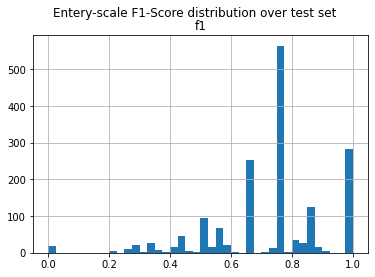

In [44]:
import pylab as pl

df.hist(column='f1',bins=40,sharey=True, sharex=True)
pl.suptitle('Entery-scale F1-Score distribution over test set')

### 15-Top worst

In [45]:
for i in range(0,16):
    print(f"INDEX {i}")
    print(df.iloc[i]["entry"])
    print(df.iloc[i]["entry_xml"])
    print(f"F1-Score : {df.iloc[i]['f1']}")
    print("")

INDEX 0
— Bourguignon freres A-T-ELDITES, i —  R. Notre-Dan S
—<PER> Bourguignon freres A-T-ELDITES</PER>, i — <LOC> R. Notre-Dan</LOC> S
F1-Score : 0.0

INDEX 1
ET H.SEnt IFF Pif
<PER>ET H.SEnt</PER><TITRE> </TITRE>IFF Pif
F1-Score : 0.0

INDEX 2
DRTIELY ÉH DOEIENEAH.S. DeN  1E
<PER>DRTIELY ÉH DOEIENEAH.</PER><TITRE>S.</TITRE> DeN  1E
F1-Score : 0.0

INDEX 3
Davleci HlsiirH,IL. aeTroura restai
<PER>Davleci</PER> <TITRE>HlsiirH,IL</TITRE>. aeT<LOC>roura</LOC> restai
F1-Score : 0.0

INDEX 4
W  E  TV1 DEen , L DHtave 114
W  E  TV1<PER> DEen ,</PER> <TITRE>L</TITRE> DHtave 114
F1-Score : 0.0

INDEX 5
BaunierpB Pomonnerie slilo.
<PER>BaunierpB</PER> <ACT>Pomonnerie slilo</ACT><LOC>.</LOC>
F1-Score : 0.0

INDEX 6
— Boyer el. Alary frères (en botte), R. *2 N.StMeryr 4L. . M . 2. — — T
—<PER> Boyer el. Alary frères (en botte),</PER> <TITRE>R. *2</TITRE><LOC> N.StMeryr</LOC> 4L. . M . 2. — — T
F1-Score : 0.0

INDEX 7
Chambert (raa) (en sros  venot, 24. R. Thé-
<PER>Chambert (raa) (</PER><ACT>e

### 15-Top best

In [46]:
rdf = df.sort_values(by='f1', ascending=False)
for i in range(0,16):
    print(rdf.iloc[i]["entry"])
    print(rdf.iloc[i]["entry_xml"])
    print(f"F1-Score : {rdf.iloc[i]['f1']}")
    print("")

Aubertin, professeur au lycée Louis-le-Grand, Saints-Pères, 7.
<PER>Aubertin</PER>, <ACT>professeur</ACT> au lycée Louis-le-Grand,<LOC> Saints-Pères</LOC>, <CARDINAL>7</CARDINAL>.
F1-Score : 1.0

Thierry , rue de Grenelle-Saint-Ger- main, 27.
<PER>Thierry</PER> , <LOC>rue de Grenelle-Saint-Ger- main</LOC>, <CARDINAL>27</CARDINAL>.
F1-Score : 1.0

Boutreux, avenue de Saxe, 8.
<PER>Boutreux</PER>, <LOC>avenue de Saxe</LOC>, <CARDINAL>8</CARDINAL>.
F1-Score : 1.0

Turgot , rue Saint-Lazare, 58.
<PER>Turgot</PER> , <LOC>rue Saint-Lazare</LOC>, <CARDINAL>58</CARDINAL>.
F1-Score : 1.0

Briollet, St-Lazare, 106.
<PER>Briollet</PER>, <LOC>St-Lazare</LOC>,<CARDINAL> 106</CARDINAL>.
F1-Score : 1.0

Texier, rue Saint-Lazare , 80.
<PER>Texier</PER>, <LOC>rue Saint-Lazare</LOC> , <CARDINAL>80</CARDINAL>.
F1-Score : 1.0

Deschamps, Chevert, 15.
<PER>Deschamps</PER>, <LOC>Chevert</LOC>, <CARDINAL>15</CARDINAL>.
F1-Score : 1.0

Torras, rue du Mont-Blanc , 28.
<PER>Torras</PER>, <LOC>rue du Mont-Blanc<

## Sub-word global analysis

In [47]:
flat_preds = []
flat_labels = []
for i in range(len(df)):
    flat_preds += df["tags_preds"][i]
    flat_labels += df["tags_gold"][i]
flat_preds = pd.Series(flat_preds, name="Predictions")
flat_labels = pd.Series(flat_labels, name="Gold")

global_confusion = pd.crosstab(flat_labels, flat_preds,normalize='index').multiply(100., axis=1)
global_confusion.columns = ['ACT','CARDINAL','FT','LOC','PER','TITRE','O']
global_confusion.index = ['ACT','CARDINAL','FT','LOC','PER','TITRE','O']
global_confusion

,ACT,CARDINAL,FT,LOC,PER,TITRE,O
ACT,91.211790,0.000000,0.018195,1.109898,2.601892,0.036390,5.021834
CARDINAL,0.107411,94.307197,0.000000,0.268528,0.000000,0.000000,5.316864
FT,24.489796,2.040816,18.367347,2.040816,0.000000,0.000000,53.061224
LOC,0.715386,0.011006,0.000000,97.149461,0.264143,0.187101,1.672903
PER,0.360065,0.000000,0.000000,0.261866,97.855974,0.130933,1.391162
TITRE,6.886228,0.299401,0.000000,0.000000,6.287425,62.574850,23.952096
O,25.828399,0.844148,0.000000,4.321532,2.645836,0.214187,66.145899


Confusion matrix of reference and predicted tokens types.
Values are normalized by row (percentage of each reference classe and its resultants predictions)
Last row represent percentage of each class in gold.


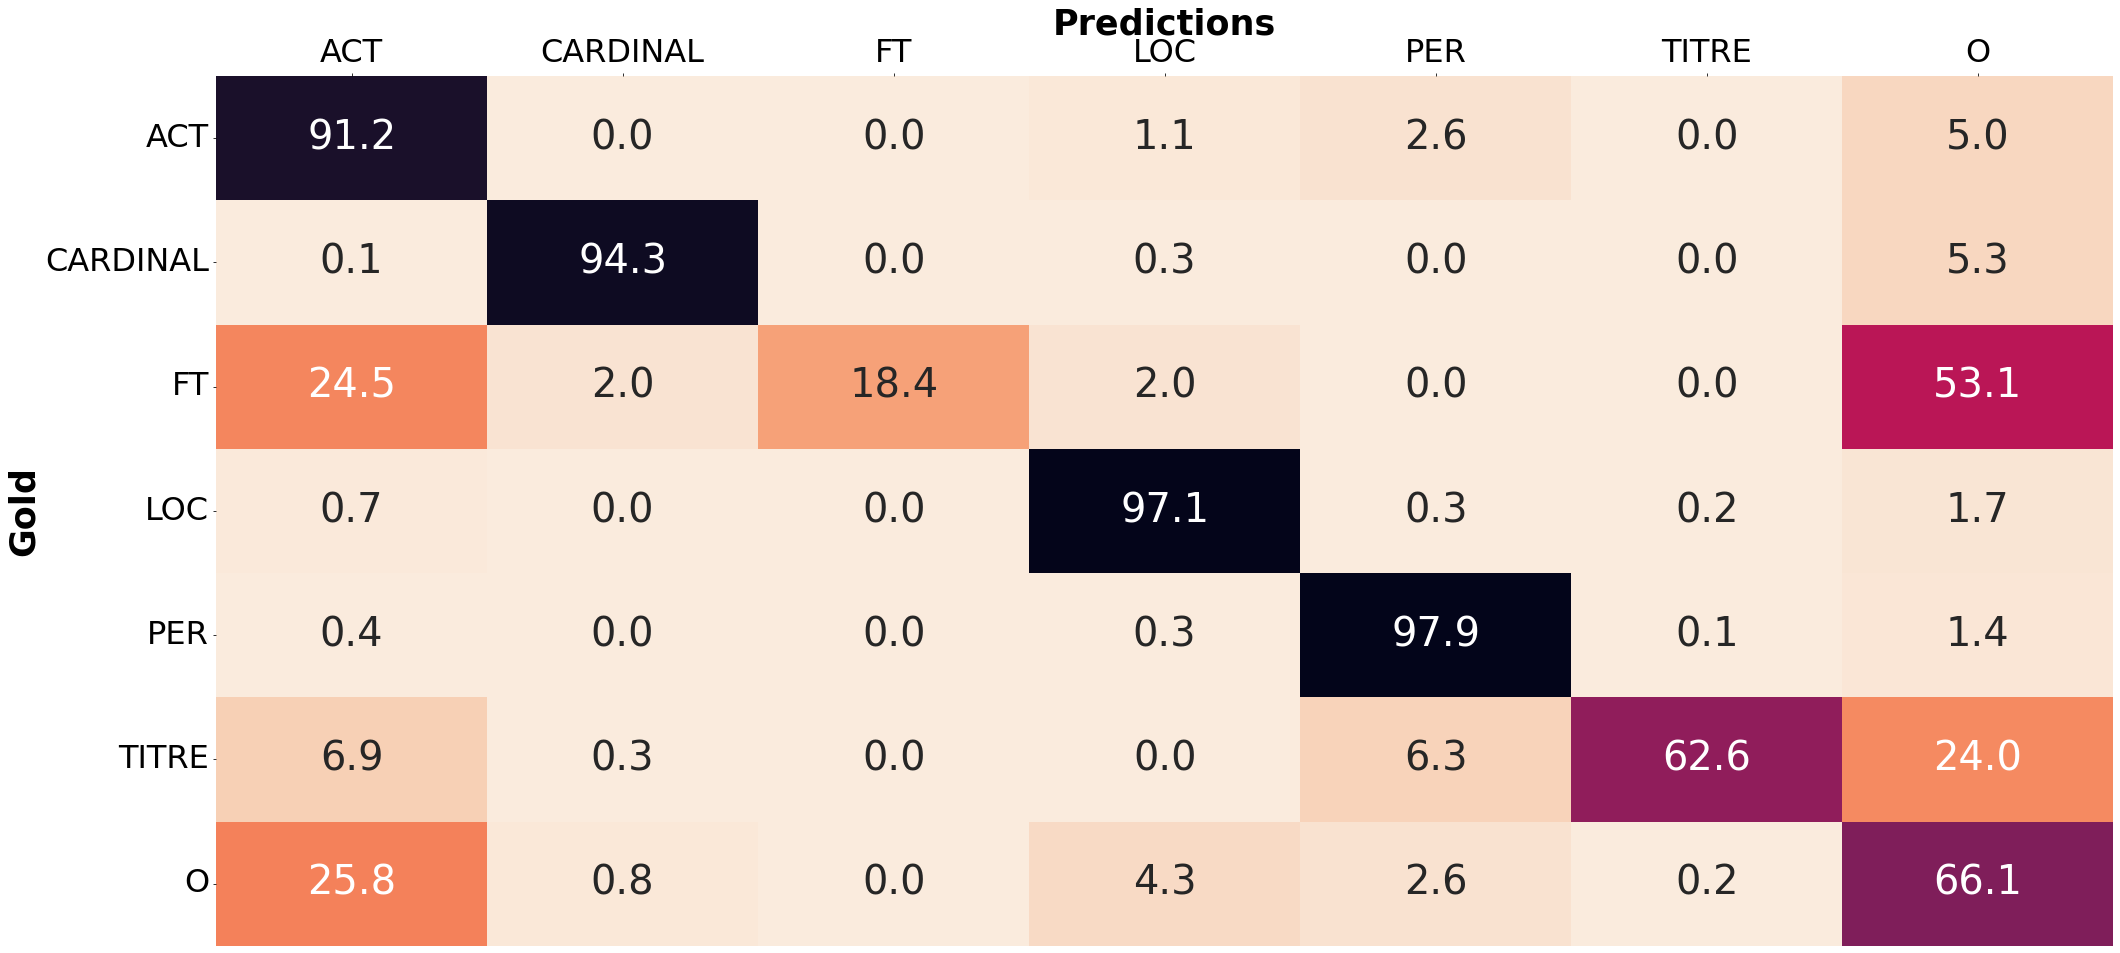

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Init figure
plt.figure(figsize=(34, 16))

#Create heatmap
snsfig = sns.heatmap(
    global_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt=".1f",
    cbar=False,
    annot_kws={"fontsize":40}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=35) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=35) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 32)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 32)

print("Confusion matrix of reference and predicted tokens types.")
print("Values are normalized by row (percentage of each reference classe and its resultants predictions)")
print("Last row represent percentage of each class in gold.")

plt.show()

#Save figure
fig = snsfig.get_figure()
fig.tight_layout()
fig.savefig(f"./tokenscaleanalysis-{MODEL}-{SET}-{FORMAT}.pdf") 

## Entry scale analysis

Please choose one entry giving its index to perform an entry scale analysis :

In [49]:
i = 15

In [50]:
print(df.iloc[i]["entry"])
print(df.iloc[i]["entry_xml"])

17 Hpnariug Etaees a aparanue  du Trih a de pierresprlop. r Fu Par --
17<PER> Hpnariug Etaees</PER> a aparanue  du <ACT>Trih a de pierres</ACT>pr<ACT>lop</ACT>.<LOC> r Fu Par</LOC> --


In [51]:
from seqeval.metrics import classification_report

y_preds = df.iloc[i]["tags_preds"]
y_true = df.iloc[i]["tags_gold"]
print(classification_report([y_true],[y_preds]))

              precision    recall  f1-score   support

         ACT       0.00      0.00      0.00         1
    CARDINAL       0.00      0.00      0.00         1
         LOC       0.00      0.00      0.00         1
         PER       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         4
   macro avg       0.00      0.00      0.00         4
weighted avg       0.00      0.00      0.00         4



/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = pd.Series(df["tags_gold"].iloc[i], name='Gold')
y_pred = pd.Series(df["tags_preds"].iloc[i], name='Predictions')
entry_confusion = pd.crosstab(y_true, y_pred)
entry_confusion

Predictions,I-ACT,I-LOC,I-PER,O
Gold,,,,
I-ACT,0,0,4,5
I-CARDINAL,0,1,0,0
I-LOC,5,0,0,1
I-PER,0,0,4,0
O,1,2,1,5


Confusion matrix of reference and predicted tokens types.


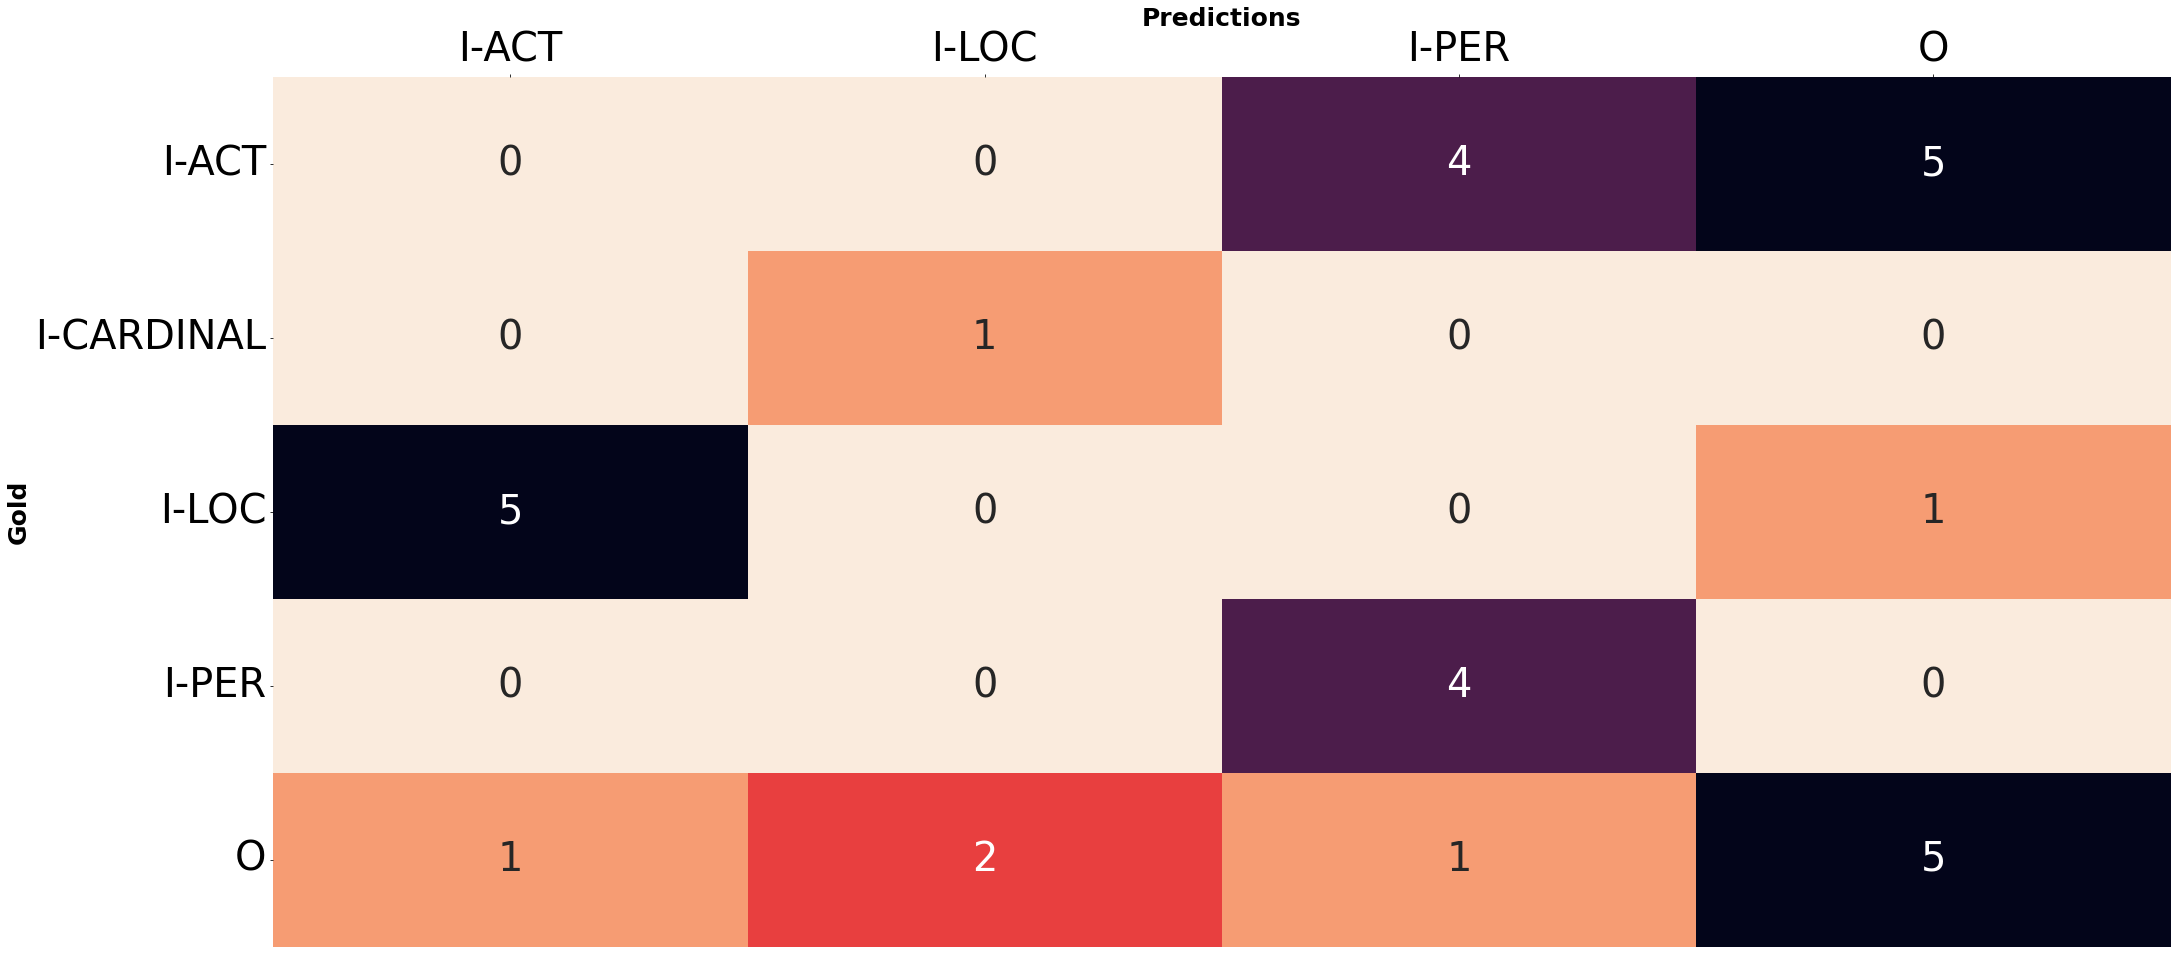

In [53]:
plt.figure(figsize=(34, 16))

#Create heatmap
snsfig = sns.heatmap(
    entry_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt="g",
    cbar=False,
    annot_kws={"fontsize":40}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=25) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=25) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 40)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 40)

print("Confusion matrix of reference and predicted tokens types.")

plt.show()

#Save figure
fig = snsfig.get_figure()